In [ ]:
# @title
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Day 17: Root-Finding Techniques for Simultaneous Systems of Equations

In the previous three notebooks we were focused on solving the single equation $f\left(x\right) = 0$, but there are higher-dimensional versions to consider. Namely,

$$\vec{f}\left(\vec{x}\right) = \vec{0}$$

which is equivalent to

$$\left\{\begin{array}{lcl} f_1\left(x_1, x_2, \cdots, x_n\right) &= & 0\\
f_2\left(x_1, x_2, \cdots, x_n\right) & = & 0\\
& \vdots &\\
f_n\left(x_1, x_2, \cdots, x_n\right) & = & 0\\
\end{array}\right.$$

Solving a system like this one is much more difficult than solving a single equation. In fact, there is no reliable method for bracketing the solution $\vec{x^*}$. This means that we can't guarantee any algorithm a "good" starting estimate unless there exist some theoretical rationale for the location of the root.

The *Newton-Raphson Method* works well with these simultaneous equations, as long as we provide a reasonable starting value.

**Motivation:** Consider that we are attempting to find solutions to the following system of non-linear equations.

$$\left\{\begin{array}{rcr} \cos\left(x\right) + \sin\left(y\right) + 1 & = & 0\\
xy - 9 & = & 0\end{array}\right.$$

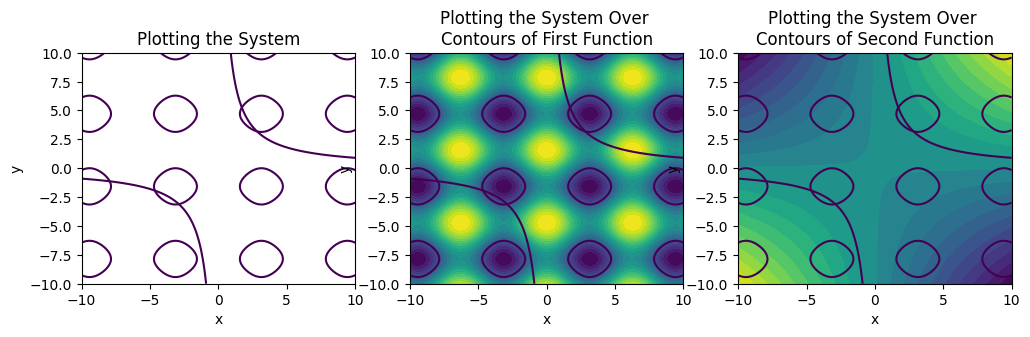

In [ ]:
#@title
def f(x, y):
  return np.cos(x) + np.sin(y) + 1.0

def g(x, y):
  return x*y - 9.0

x = np.linspace(-10, 10, 250)
y = np.linspace(-10, 10, 250)

X, Y = np.meshgrid(x, y)

Z_f = f(X, Y)
Z_g = g(X, Y)

plt.figure(figsize = (12, 3))
plt.subplot(1, 3, 1)
plt.contour(X, Y, Z_f, levels = [0])
plt.contour(X, Y, Z_g, levels = [0])
plt.xlim((-10, 10))
plt.ylim((-10, 10))
plt.xlabel("x")
plt.ylabel("y")
plt.title("Plotting the System")

plt.subplot(1, 3, 2)
plt.contour(X, Y, Z_f, levels = [0])
plt.contour(X, Y, Z_g, levels = [0])
plt.contourf(X, Y, Z_f, levels = 20)
plt.xlim((-10, 10))
plt.ylim((-10, 10))
plt.xlabel("x")
plt.ylabel("y")
plt.title("Plotting the System Over \nContours of First Function")

plt.subplot(1, 3, 3)
plt.contour(X, Y, Z_f, levels = [0])
plt.contour(X, Y, Z_g, levels = [0])
plt.contourf(X, Y, Z_g, levels = 20)
plt.xlim((-10, 10))
plt.ylim((-10, 10))
plt.xlabel("x")
plt.ylabel("y")
plt.title("Plotting the System Over \nContours of Second Function")

plt.show()

Remember that our earlier approaches to solving systems are only appropriate if each of the equations is linear in its variables. That is no longer the case here, so we'll need a new technique!

## Newton-Raphson for Nonlinear Systems

We can derive the *Newton-Raphson method* for a system of equations by beginning with the Taylor Series expansion of $f_i\left(\vec{x}\right)$ truncated to first degree about the point $\vec{x^*}$.

$$f_i\left(\vec{x^*} + \Delta\vec{x}\right) \approx f_i\left(\vec{x^*}\right) + \sum_{j = 1}^{n}{\frac{\partial f_i}{\partial x_j}\Delta x_j}$$

If we define the *Jacobian Matrix* $J\left(\vec{x^*}\right)$ to be the $n\times n$ matrix such that $\displaystyle{J_{ij} = \frac{\partial f_i}{\partial x_j}\left(\vec{x^*}\right)}$, then we can rewrite the above as the matrix equation:

$$\vec{f}\left(\vec{x^*} + \Delta \vec{x}\right) \approx \vec{f}\left(\vec{x^*}\right) + J\left(\vec{x^*}\right)\Delta\vec{x}$$

Assume that $\vec{x^*}$ is the previous approximation of the solution to $\vec{f}\left(\vec{x}\right) = \vec{0}$ and that $\left(\vec{x^*} + \Delta\vec{x}\right)$ is the improved solution. To find $\Delta\vec{x}$, we set $\vec{f}\left(\vec{x^*} + \Delta\vec{x}\right) = \vec{0}$ and get an approximate solution by solving

\begin{align*} \vec{f}\left(\vec{x^*}\right) + J\left(\vec{x^*}\right)\Delta\vec{x} &= 0\\
\implies J\left(\vec{x^*}\right)\Delta\vec{x} &= -\vec{f}\left(\vec{x^*}\right)
\end{align*}

We won't calculate each $\displaystyle{\frac{\partial f_i}{\partial x_j}}$ explicitly -- instead, we'll approximate them via the finite difference method (difference quotient). That is,

$$\frac{\partial f_i}{\partial x_j} \approx \frac{f_i\left(\vec{x^*} + \vec{e_j}h\right) - f_i\left(\vec{x^*}\right)}{h}$$

where $h$ is a small step size and $\vec{e_j}$ is the $j^{th}$ component identity vector. For example, $\displaystyle{\vec{e_2} = \left[\begin{array}{c} 0\\ 1\\ 0\\ \vdots\\ 0\end{array}\right]}$. Luckily the *Newton-Raphson Method* is relatively insensistive to small errors in $J\left(\vec{x}\right)$ -- making these approximations is very convenient because we avoid needing to compute and define each partial derivative for the routine.

We're now ready to write the routine. Just remember, that success of this method depends on having a quality initial estimate for $\vec{x^*}$. Otherwise, the results are quite unpredictable -- having some expectation for where the root should occur is necessary because we cannot follow these results blindly. Additionally, $J\left(\vec{x^*}\right) \Delta\vec{x} = - \vec{f}\left(\vec{x^*}\right)$ is system of linear equations, so we'll copy and paste our `gaussPivot()` routine from the Day 7 notebook here as well.

In [ ]:
## Gaussian Pivot for Solving Jacobian Equation
def swapRows(v, i, j):
  if len(v.shape) == 1:
    v[i], v[j] = v[j], v[i]
  else:
    v[[i, j], :] = v[[j, i], :]

def scaleFactors(A):
  n = A.shape[1]
  s = np.zeros(n)
  for i in range(n):
    s[i] = max(np.abs(A[i, :]))

  return s

def gaussPivot(A, b, tol = 1.0e-12):
  n = len(b)
  s = scaleFactors(A)

  for k in range(0, n-1):
    p = np.argmax(np.abs(A[k:n, k])/s[k:n]) + k
    if abs(A[p, k]) < tol:
      print("Matrix is Singular")
      return None

    #Row Pivot if necessary
    if p != k:
      swapRows(b, k, p)
      swapRows(s, k, p)
      swapRows(A, k, p)

    #Elimination
    for i in range(k+1, n):
      if A[i, k] != 0.0:
        lam = A[i, k]/A[k, k]
        A[i, (k+1):n] = A[i, (k+1):n] - lam*A[k, (k+1):n]
        b[i] = b[i] - lam*b[k]

  if abs(A[n-1, n-1]) < tol:
    print("Matrix is Singular")
    return None

  #back substitution
  b[n-1] = b[n-1]/A[n-1, n-1]
  for k in range(n-2, -1, -1):
    b[k] = (b[k] - np.dot(A[k, (k+1):n], b[(k+1):n]))/A[k, k]

  return b

In [ ]:
## Jacobian Constructor
def jacobian(f, x):
  h = 1.0e-4
  n = ___
  jac = np.zeros((___, ___))
  f0 = f(___)

  for i in range(n):
    temp = x[i]
    x[i] = temp + ___
    f1 = f(___)
    x[i] = temp
    jac[:, i] = ___

  return jac, f0

## Newton-Raphson Method for Multiple Dimensions
def newtonRaphsonMultiDim(f, x, tol = 1.0e-9):
  for i in range(30): #30 iterations chosen
    jac, f0 = ___(___, ___)
    #print("Jacobian \n", jac)
    #print("f0: ", f0)
    if (np.dot(f0, f0)/len(x))**0.5 < tol:
      return x

    dx = ___(___, ___)
    x = x + ___
    if (np.dot(dx, dx))**0.5 < tol*max(max(abs(x)), 1.0):
      return x

  print("Newton-Raphson did not converge.")
  return None

**Example 1:** Use the Mutli-Dimensional Newton-Raphson routine you just constructed to determine the points of intersection between the circle $x^2 + y^2 = 3$ and the hyperbola $xy = 1$.

> *Solution.*

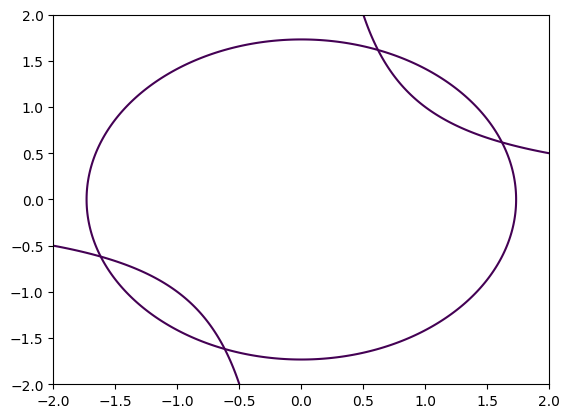

In [ ]:
#@title
def f(x, y):
  return x**2 + y**2 - 3

def g(x,y):
  return x*y - 1

x = np.linspace(-2, 2, 250)
y = np.linspace(-2, 2, 250)

#xy_df = pd.DataFrame(itertools.product(x, y), columns = ["x", "y"])
#xy_df["f"] = f(xy_df["x"], xy_df["y"])
#xy_df["g"] = g(xy_df["x"], xy_df["y"])
#xy_f_contour_df = xy_df[abs(xy_df["f"]) < 0.01]
#xy_g_contour_df = xy_df[abs(xy_df["g"]) < 0.01]

#plt.scatter(xy_f_contour_df["x"], xy_f_contour_df["y"])
#plt.scatter(xy_g_contour_df["x"], xy_g_contour_df["y"])

X, Y = np.meshgrid(x, y)
Z_f = f(X, Y)
Z_g = g(X, Y)

#plt.contour(X, Y, Z_f, levels = 50)
#plt.contour(X, Y, Z_g, levels = 50)
plt.contour(X, Y, Z_f, levels = [0])
plt.contour(X, Y, Z_g, levels = [0])
plt.xlim((-2, 2))
plt.ylim((-2, 2))

plt.show()

In [ ]:
def f(x):
  F = np.zeros(2)
  F[0] = x[0]**2 + x[1]**2 -3
  F[1] = x[0]*x[1] - 1

  return F

est_intersection = newtonRaphsonMultiDim(f, [0, -0.1])

print("I found the intersection to be ", est_intersection)

I found the intersection to be  [-0.61803399 -1.61803399]


In [ ]:
# @title
def f_vec(x):
  f = np.zeros(len(x))
  f[0] = x[0]**2 + x[1]**2 - 3
  f[1] = x[0]*x[1] -1

  return f

x = np.array([0.5, 2])

newtonRaphsonMultiDim(f_vec, x)

**Example 2:** Find a solution to the system

$$\left\{\begin{array}{rcr} \sin\left(x\right) + y^2 + \ln\left(z\right) - 7 &= 0\\
3x + 2^y - z^3 + 1 &= 0\\
x + y + z - 5 &= 0\end{array}\right.$$

A solution exists near $\left(1, 1, 1\right)$.

> *Solution.*